<center>
 Object Detection Using Yolov5 (Python)
</center>

In [3]:

import time, random
import numpy as np
import pandas as pd
import cv2, torch
from tqdm.auto import tqdm
import shutil as sh

from IPython.display import Image, clear_output
import matplotlib.pyplot as plt

import os
import torch
from torchvision import models, transforms
from PIL import Image, ImageDraw

Loading and preparing the dataset 

In [4]:
img_h, img_w, num_channels = (380, 676, 3)
df = pd.read_csv('data/train_solution_bounding_boxes.csv')
df.rename(columns={'image':'image_id'}, inplace=True)
df['image_id'] = df['image_id'].apply(lambda x: x.split('.')[0])
df['x_center'] = (df['xmin'] + df['xmax'])/2
df['y_center'] = (df['ymin'] + df['ymax'])/2
df['w'] = df['xmax'] - df['xmin']
df['h'] = df['ymax'] - df['ymin']
df['classes'] = 0
df['x_center'] = df['x_center']/img_w
df['w'] = df['w']/img_w
df['y_center'] = df['y_center']/img_h
df['h'] = df['h']/img_h

Reviewing Sample image

Image ID: vid_4_21540


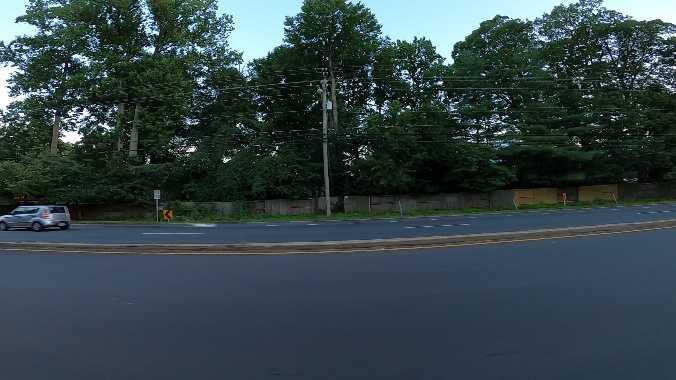

In [10]:
from IPython.display import Image


index = list(set(df.image_id))
image = random.choice(index)
print("Image ID: %s"%(image))
img = cv2.imread(f'data/training_images/{image}.jpg')
image = random.choice(index)
display(Image(filename=f'data/training_images/{image}.jpg',width=600))

Training the machine learning model to detect objects using Python

In [11]:
source = 'training_images'
if True:
    for fold in [0]:
        val_index = index[len(index)*fold//5:len(index)*(fold+1)//5]
        for name,mini in tqdm(df.groupby('image_id')):
            if name in val_index:
                path2save = 'val2023/'
            else:
                path2save = 'train2023/'
            if not os.path.exists('/tmp/convertor/fold{}/labels/'.format(fold)+path2save):
                os.makedirs('/tmp/convertor/fold{}/labels/'.format(fold)+path2save)
            with open('/tmp/convertor/fold{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
                row = mini[['classes','x_center','y_center','w','h']].astype(float).values
                row = row.astype(str)
                for j in range(len(row)):
                    text = ' '.join(row[j])
                    f.write(text)
                    f.write("\n")
            if not os.path.exists('/tmp/convertor/fold{}/images/{}'.format(fold,path2save)):
                os.makedirs('/tmp/convertor/fold{}/images/{}'.format(fold,path2save))
            sh.copy("data/{}/{}.jpg".format(source,name),'/tmp/convertor/fold{}/images/{}/{}.jpg'.format(fold,path2save,name))

100%|██████████| 355/355 [00:03<00:00, 92.88it/s] 


Object Detection

In [ ]:
from PIL import Image as PILImage

def transform_image(image):
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    return transform(image).unsqueeze(0)

def detect_and_save_objects(image_path, output_path, model):
    image = PILImage.open(image_path).convert('RGB')
    image_tensor = transform_image(image)
    
    with torch.no_grad():
        prediction = model(image_tensor)
   
    draw = ImageDraw.Draw(image)
    for element in prediction[0]['boxes']:
        box = element.cpu().numpy()
        draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red', width=3)
    

    image.save(output_path)

# Set the directory for input images and the output directory
input_dir = 'data/training_images' 
output_dir = 'inference/output'


if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Load a pre-trained Faster R-CNN model
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval() 

# Run object detection on all images in the input directory
for image_file in os.listdir(input_dir):
    if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):  
        image_path = os.path.join(input_dir, image_file)
        output_path = os.path.join(output_dir, 'detected_' + image_file) 
        detect_and_save_objects(image_path, output_path, model)

print(f"Object detection completed. Results saved in '{output_dir}'.")


Looking in directory: inference/output
Found 451 files.


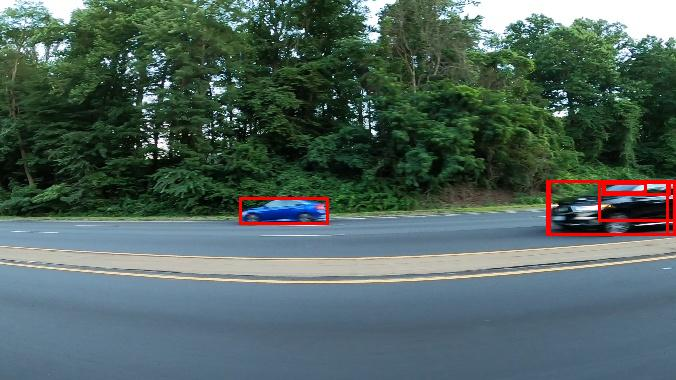

In [69]:
predicted_files = []
for (dirpath, dirnames, filenames) in os.walk("inference/output"):
    print(f"Looking in directory: {dirpath}") 
    for file in filenames:
        if file.endswith('.jpg'):  
            predicted_files.append(os.path.join(dirpath, file))

if predicted_files:
    print(f"Found {len(predicted_files)} files.")  
    random_file = random.choice(predicted_files)
    display(Image(filename=random_file))
else:
    print("No files found in 'inference/output'")